In [1]:
%cd ~/dev/event-camera/src

/home/gianscarpe/dev/event-camera/src


In [2]:
from experimenting.dataset.factory import Joints3DConstructor
from experimenting.dataset import get_dataloader

from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics, losses

from omegaconf import DictConfig

from experimenting.utils import get_file_paths, plot_heatmap, plot_skeleton_3d, denormalize_predict
import numpy as np
import glob
import os

%matplotlib inline

In [116]:
homedir = '/data/gscarpellini/dhp19'
dataset = 'time_count_dataset'
exp_dataset = 'timecount'


data_dir = os.path.join(homedir, dataset, 'movements_per_frame')
labels_dir = os.path.join(homedir, dataset, "labels_full_joints/")

test_subjects = [1, 2, 3, 4, 5]
cams = [0,1,2,3]

batch_size = 32

hparams = DictConfig({'dataset':{'data_dir': data_dir, 'core_class': 'DHP19Core', 'save_split':False, 'hm_dir': labels_dir,'joints_dir' :
                      labels_dir, 'test_subjects':test_subjects, 'split_at':0.8, 'cams': cams,
                                'movements': [0]}, 
                       'augmentation_test': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}},
                      'augmentation_train': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}}
                     })

In [117]:
factory = Joints3DConstructor(hparams)
train, val, test = factory.get_datasets()
loader = get_dataloader(test, batch_size, shuffle=False, num_workers=2)

.npy|.mat


In [155]:
train, val, test = factory.get_datasets()

In [119]:
loader = get_dataloader(test, batch_size, shuffle=False, num_workers=2)
batch = next(iter(loader))
x, y = batch

In [120]:
batch = next(iter(loader))
x, y = batch

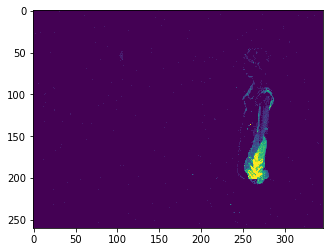

In [148]:
plt.imshow(np.squeeze(x[1].numpy()))

## Eval margipose model

In [68]:
ls /home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/

08-31-15-54_exp_ae_resnet34_cut_512_pretrained_True_08-31-15-54/
09-02-10-10_exp_resnet34_pretrained_True_09-02-10-10/
09-02-11-18_exp_resnet34_pretrained_True_09-02-11-18/
09-02-11-24_exp_resnet34_pretrained_True_09-02-11-24/
09-02-11-27_exp_resnet34_pretrained_True_09-02-11-27/
09-02-11-34_exp_resnet34_pretrained_True_09-02-11-34/
09-02-11-37_exp_resnet34_pretrained_True_09-02-11-37/
09-02-11-45_exp_resnet34_pretrained_True_09-02-11-45/
09-02-11-49_exp_resnet34_pretrained_True_09-02-11-49/
09-02-11-50_exp_resnet34_pretrained_True_09-02-11-50/
09-02-13-32_exp_resnet34_pretrained_True_09-02-13-32/
cross-subject/
exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22/
with_errors/


In [70]:
exp_dir = f'/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator'

exps = sorted(glob.glob(os.path.join(exp_dir,'exp*')))
print(list(exps))

['/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/exp_ae_resnet34_cut_256_$Adam_0.0003_no_aug_08-24-11-22']


In [185]:
import experimenting.agents as agents
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.utils import get_joints_from_heatmap, average_loss, decompose_projection_matrix, plot_skeleton_3d, reproject_skeleton
import experimenting.utils.cv_helpers as utils

reload(agents)
exp_name = "08-31-15-54_exp_ae_resnet34_cut_512_pretrained_True_08-31-15-54/"
checkpoint_dir = os.path.join(exp_dir, exp_name, 'checkpoints')
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[1])
model = agents.MargiposeEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [166]:
checkpoint_path

'/home/gianscarpe/dev/exps/timecount_dhp19/exps_MargiposeEstimator/08-31-15-54_exp_ae_resnet34_cut_512_pretrained_True_08-31-15-54/checkpoints/epoch=24-val_loss=0.07.ckpt'

PRED XY


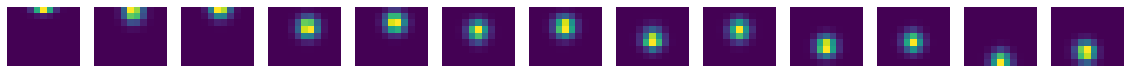

PRED ZY


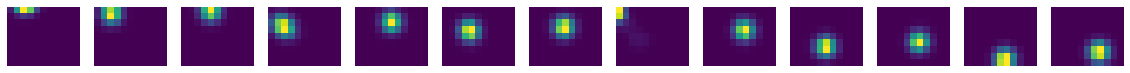

PRED XZ


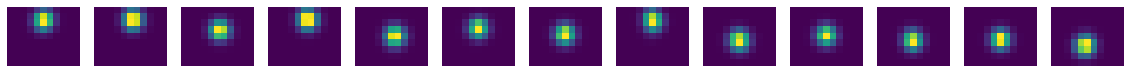

In [167]:
idx = 0

y_sample = np.load(test.dataset.joints[test.x_indexes[0]])
x_sample, _ = test[idx]

with torch.no_grad():
    preds = model(x_sample.unsqueeze(0))

#plt.imshow(x_sample.squeeze())

# XY
print("PRED XY")
plot_heatmap(preds[0][-1][0])

# ZY
print("PRED ZY")
plot_heatmap(preds[1][-1][0])

# XZ
print("PRED XZ")
plot_heatmap(preds[2][-1][0])


In [147]:
torch.sum(preds[-1][-1][0])

tensor(13.0000)

In [168]:
with torch.no_grad():
        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)
_, denorm_model_pred = model.get_denormalized_pred_gt_skeletons(preds, y)

In [186]:
denorm_model_pred[0]

tensor([[  397.2419,  -150.9808,  -160.2748],
        [  322.0759,   -41.2231,  -272.4479],
        [  347.5229,   -33.1856,  -193.5634],
        [  104.7222,     8.7051,  -618.2843],
        [  190.0579,    -3.9061,  -438.7164],
        [   83.5083,  -177.8969,  -670.6921],
        [  134.5388,  -171.0596,  -564.6650],
        [  -40.7671,  -132.1280,  -876.3682],
        [   84.5522,  -151.0306,  -630.4813],
        [ -149.6746,  -164.7210, -1043.0236],
        [  -85.8218,  -164.4493,  -919.6987],
        [ -327.4158,  -219.3330, -1339.2368],
        [ -242.6277,  -236.1379, -1181.7311]])

In [180]:
normalized_skeletons[0]

tensor([[-1.7561e-03, -8.7326e-01, -5.4115e-01],
        [ 7.3244e-02, -7.1370e-01, -5.7827e-01],
        [ 7.9927e-02, -8.0358e-01, -1.9129e-01],
        [ 1.0500e-01, -2.3165e-01, -4.1406e-01],
        [ 9.8160e-02, -4.6111e-01, -6.4061e-04],
        [-2.3895e-02, -1.6784e-01, -2.4188e-01],
        [-1.7714e-02, -3.0399e-01, -3.7662e-02],
        [ 5.8236e-03,  1.1414e-01, -2.7068e-01],
        [-4.0743e-03, -2.0734e-01,  1.3566e-01],
        [-1.7326e-02,  3.4516e-01, -5.8256e-03],
        [-1.5638e-02,  1.8295e-01,  1.5978e-01],
        [-5.6750e-02,  7.4529e-01,  1.5716e-01],
        [-6.6262e-02,  5.3556e-01,  3.3898e-01]])

In [178]:
    mp = metrics.MPJPE(reduction=average_loss)
    reload(utils)
    with torch.no_grad():
        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)
    i = 0
    camera = y['camera'][i]
    M = y['M'][i]
    xyz_gt = y['xyz'][i]
    
    pred_skeleton = normalized_skeletons[i].narrow(-1, 0, 3)
    pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                        width=260, height=346, camera=camera, z_ref=y['z_ref'][i]).transpose(1, 0)
    xyz_pred = utils.reproject_skeleton(M, pred_skeleton)
    print(xyz_gt)
    print(xyz_pred)
    print(mp(xyz_gt, xyz_pred))
    print(M)

tensor([[   9.5219,  112.9674, 1745.5894],
        [-160.8327,  216.9867, 1443.0616],
        [ 168.9559,  241.0572, 1445.8483],
        [-198.1027,  263.3254, 1121.8134],
        [ 191.5877,  287.9673, 1134.5719],
        [-112.6563,  113.1119, 1014.0953],
        [ 104.5871,  118.3244, 1026.7002],
        [-214.9593,  136.8615,  834.1327],
        [ 246.9135,  163.0286,  824.6191],
        [ -42.7847,  145.5574,  527.9327],
        [  43.3501,  152.3948,  532.0093],
        [ -56.4227,  106.3037,   72.6593],
        [  54.3537,  112.0850,   72.7647]], dtype=torch.float64)
tensor([[-128.2703,   90.2459, 1567.5072],
        [-217.9811,  176.5125, 1485.3398],
        [ 140.8766,  225.7370, 1444.5013],
        [-272.9979,  235.4456, 1145.4969],
        [ 191.6665,  281.3080, 1135.0471],
        [-149.1887,   87.8535, 1026.1918],
        [  96.3086,  110.8417, 1028.0538],
        [-286.0269,  126.9343,  854.3546],
        [ 241.5693,  148.7671,  864.1835],
        [-153.0242,  120.0456,  

In [255]:
def get_skeleton_torso_length(skeleton):
    """
    alculates the length of skeleton torso in input m.u.
    """
    middle_shoulders_point = skeleton.index_select(0, torch.LongTensor([1, 2])).mean(0)
    middle_hips_point = skeleton.index_select(0, torch.LongTensor([5, 6])).mean(0)
    return abs(torch.norm(middle_shoulders_point - middle_hips_point))

In [209]:
torch.mean([xyz_gt[2], xyz_gt[1]])

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [218]:
loader_val = get_dataloader(val, batch_size, shuffle=True, num_workers=2)
batch_val = next(iter(loader_val))
_, y_val = batch_val

In [211]:
xyz_gt.index_select(0, torch.LongTensor([2, 1])).mean(0)

tensor([   4.0616,  229.0220, 1444.4550], dtype=torch.float64)

In [212]:
xyz_gt.index_select(0, torch.LongTensor([6, 5])).mean(0)

tensor([  -4.0346,  115.7182, 1020.3977], dtype=torch.float64)

In [271]:
torso_length_mean = torch.mean(torch.tensor([utils.get_skeleton_height(i) for i in y_val['xyz']]))

In [277]:
torch.tensor([utils.get_skeleton_longitudinal_lenght(i) for i in y_val['xyz']]) / torch.tensor([utils.get_skeleton_height(i) for i in y_val['xyz']])

tensor([0.9509, 0.9346, 0.9394, 0.9165, 0.9209, 0.9373, 0.9710, 0.9501, 0.9675,
        0.8975, 0.9581, 0.9794, 0.9591, 0.9252, 0.8745, 0.9577, 0.9799, 0.9444,
        0.9732, 0.9231, 0.9455, 0.9536, 0.9467, 0.9361, 0.9368, 0.9189, 0.9469,
        0.9775, 0.9629, 0.9694, 0.9244, 0.9736], dtype=torch.float64)

In [159]:
test.dataset.file_paths[test.x_indexes[0]]

'/data/gscarpellini/dhp19/time_count_dataset/movements_per_frame/S1_session_1_mov_1_frame_0_cam_0.npy'

In [237]:
f = lambda x: get_skeleton_torso_length(x) - 440

In [257]:
get_skeleton_torso_length(i) 

AttributeError: 'int' object has no attribute 'index_select'

In [288]:
import experimenting.utils.skeleton_helpers as skeleton_helpers
reload(skeleton_helpers)

<module 'experimenting.utils.skeleton_helpers' from '/home/gianscarpe/dev/event-camera/src/experimenting/utils/skeleton_helpers.py'>

In [320]:
normalized_skeletons[i].narrow(-1, 0, 3)

tensor([[-1.7561e-03, -8.7326e-01, -5.4115e-01],
        [ 7.3244e-02, -7.1370e-01, -5.7827e-01],
        [ 7.9927e-02, -8.0358e-01, -1.9129e-01],
        [ 1.0500e-01, -2.3165e-01, -4.1406e-01],
        [ 9.8160e-02, -4.6111e-01, -6.4061e-04],
        [-2.3895e-02, -1.6784e-01, -2.4188e-01],
        [-1.7714e-02, -3.0399e-01, -3.7662e-02],
        [ 5.8236e-03,  1.1414e-01, -2.7068e-01],
        [-4.0743e-03, -2.0734e-01,  1.3566e-01],
        [-1.7326e-02,  3.4516e-01, -5.8256e-03],
        [-1.5638e-02,  1.8295e-01,  1.5978e-01],
        [-5.6750e-02,  7.4529e-01,  1.5716e-01],
        [-6.6262e-02,  5.3556e-01,  3.3898e-01]])

In [327]:
reload(skeleton_helpers)
skeleton_helpers.Skeleton(normalized_skeletons[i].narrow(-1, 0, 3)).denormalize(260, 346, z_ref=y['z_ref'][i], camera=camera)._get_tensor()

tensor([[-2.0787e+00, -6.0634e+02,  2.1828e+03,  1.0000e+00],
        [ 8.5580e+01, -4.8916e+02,  2.1547e+03,  1.0000e+00],
        [ 1.0788e+02, -6.3623e+02,  2.4890e+03,  1.0000e+00],
        [ 1.3010e+02, -1.6837e+02,  2.2849e+03,  1.0000e+00],
        [ 1.4345e+02, -3.9530e+02,  2.6950e+03,  1.0000e+00],
        [-3.1610e+01, -1.3024e+02,  2.4395e+03,  1.0000e+00],
        [-2.5477e+01, -2.5648e+02,  2.6524e+03,  1.0000e+00],
        [ 7.6177e+00,  8.7579e+01,  2.4122e+03,  1.0000e+00],
        [-6.3287e+00, -1.8893e+02,  2.8645e+03,  1.0000e+00],
        [-2.5263e+01,  2.9523e+02,  2.6890e+03,  1.0000e+00],
        [-2.4564e+01,  1.6857e+02,  2.8967e+03,  1.0000e+00],
        [-8.9034e+01,  6.8590e+02,  2.8932e+03,  1.0000e+00],
        [-1.1358e+02,  5.3851e+02,  3.1611e+03,  1.0000e+00]])


tensor([[-2.0787e+00, -6.0634e+02,  2.1828e+03,  1.0000e+00],
        [ 8.5580e+01, -4.8916e+02,  2.1547e+03,  1.0000e+00],
        [ 1.0788e+02, -6.3623e+02,  2.4890e+03,  1.0000e+00],
        [ 1.3010e+02, -1.6837e+02,  2.2849e+03,  1.0000e+00],
        [ 1.4345e+02, -3.9530e+02,  2.6950e+03,  1.0000e+00],
        [-3.1610e+01, -1.3024e+02,  2.4395e+03,  1.0000e+00],
        [-2.5477e+01, -2.5648e+02,  2.6524e+03,  1.0000e+00],
        [ 7.6177e+00,  8.7579e+01,  2.4122e+03,  1.0000e+00],
        [-6.3287e+00, -1.8893e+02,  2.8645e+03,  1.0000e+00],
        [-2.5263e+01,  2.9523e+02,  2.6890e+03,  1.0000e+00],
        [-2.4564e+01,  1.6857e+02,  2.8967e+03,  1.0000e+00],
        [-8.9034e+01,  6.8590e+02,  2.8932e+03,  1.0000e+00],
        [-1.1358e+02,  5.3851e+02,  3.1611e+03,  1.0000e+00]])

In [342]:
reload(skeleton_helpers)
reload(utils)
skeleton_helpers.Skeleton(normalized_skeletons[i].narrow(-1, 0, 3)).denormalize(260, 346, z_ref=y['z_ref'][i], camera=camera).reproject_onto_world(y['M'][i])._get_tensor()

torch.Size([13, 3])
tensor([[-2.0787e+00, -6.0634e+02,  2.1828e+03,  1.0000e+00],
        [ 8.5580e+01, -4.8916e+02,  2.1547e+03,  1.0000e+00],
        [ 1.0788e+02, -6.3623e+02,  2.4890e+03,  1.0000e+00],
        [ 1.3010e+02, -1.6837e+02,  2.2849e+03,  1.0000e+00],
        [ 1.4345e+02, -3.9530e+02,  2.6950e+03,  1.0000e+00],
        [-3.1610e+01, -1.3024e+02,  2.4395e+03,  1.0000e+00],
        [-2.5477e+01, -2.5648e+02,  2.6524e+03,  1.0000e+00],
        [ 7.6177e+00,  8.7579e+01,  2.4122e+03,  1.0000e+00],
        [-6.3287e+00, -1.8893e+02,  2.8645e+03,  1.0000e+00],
        [-2.5263e+01,  2.9523e+02,  2.6890e+03,  1.0000e+00],
        [-2.4564e+01,  1.6857e+02,  2.8967e+03,  1.0000e+00],
        [-8.9034e+01,  6.8590e+02,  2.8932e+03,  1.0000e+00],
        [-1.1358e+02,  5.3851e+02,  3.1611e+03,  1.0000e+00]])
torch.Size([13, 3])
torch.Size([13, 4])
torch.Size([4, 13])
OK
torch.Size([3, 13])
torch.Size([13, 3])


tensor([[-1.3067e+02,  9.0049e+01,  1.5681e+03,  1.0000e+00],
        [-2.2041e+02,  1.7621e+02,  1.4861e+03,  1.0000e+00],
        [ 1.3979e+02,  2.2560e+02,  1.4448e+03,  1.0000e+00],
        [-2.7479e+02,  2.3516e+02,  1.1464e+03,  1.0000e+00],
        [ 1.9166e+02,  2.8131e+02,  1.1350e+03,  1.0000e+00],
        [-1.5037e+02,  8.7757e+01,  1.0268e+03,  1.0000e+00],
        [ 9.6085e+01,  1.1082e+02,  1.0282e+03,  1.0000e+00],
        [-2.8726e+02,  1.2680e+02,  8.5514e+02,  1.0000e+00],
        [ 2.4249e+02,  1.4885e+02,  8.6372e+02,  1.0000e+00],
        [-1.5306e+02,  1.2004e+02,  5.3464e+02,  1.0000e+00],
        [ 8.9649e+01,  1.3726e+02,  5.3863e+02,  1.0000e+00],
        [-1.7201e+02,  7.8220e+01,  9.1587e+01,  1.0000e+00],
        [ 1.3454e+02,  7.5227e+01,  8.1704e+01,  1.0000e+00]])

tensor([75.1830], dtype=torch.float64)
tensor([226.8628], dtype=torch.float64)
tensor([87.7013], dtype=torch.float64)
tensor([126.6369], dtype=torch.float64)
tensor([119.3216], dtype=torch.float64)
tensor([371.4819], dtype=torch.float64)
tensor([272.8766], dtype=torch.float64)
tensor([268.4868], dtype=torch.float64)
tensor([180.8919], dtype=torch.float64)
tensor([405.5978], dtype=torch.float64)
tensor([465.0574], dtype=torch.float64)
tensor([301.4286], dtype=torch.float64)
tensor([80.5425], dtype=torch.float64)
tensor([301.3542], dtype=torch.float64)
tensor([60.5910], dtype=torch.float64)
tensor([132.7107], dtype=torch.float64)
MEAN: tensor([217.2953], dtype=torch.float64)


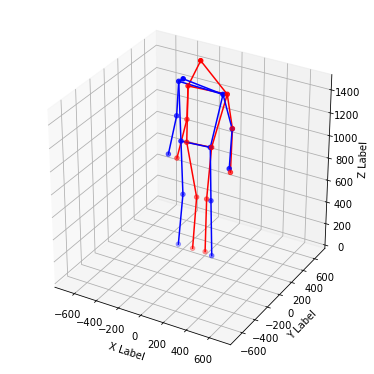

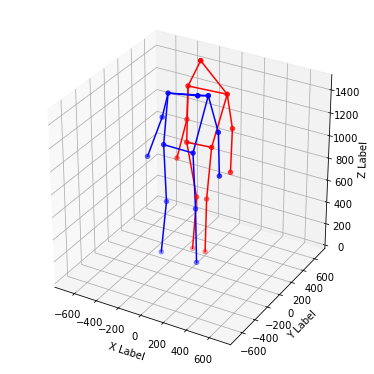

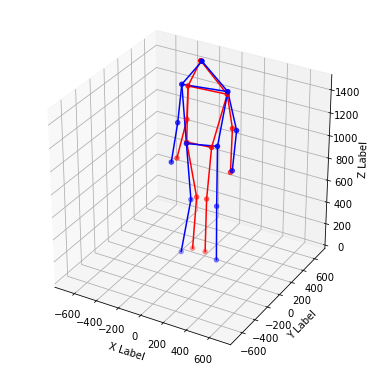

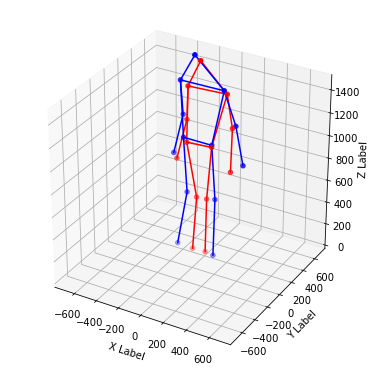

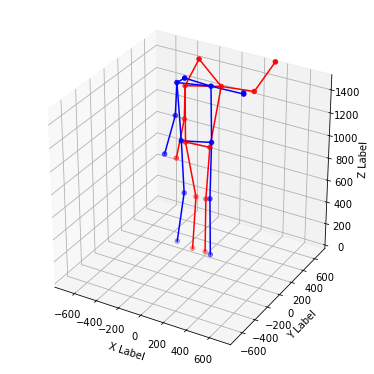

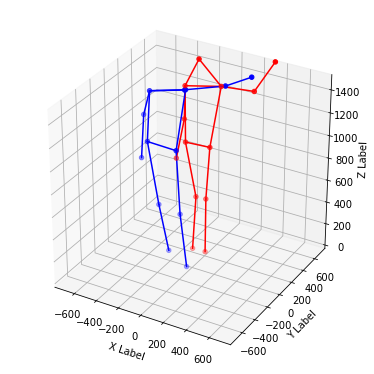

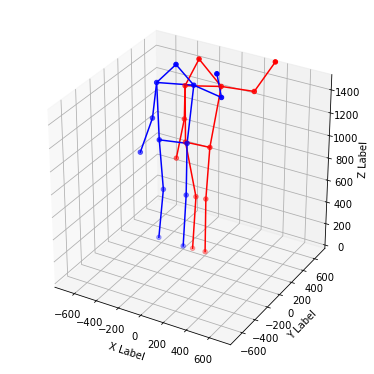

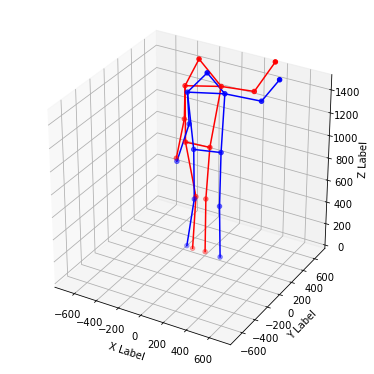

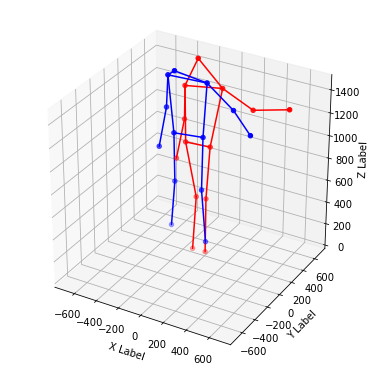

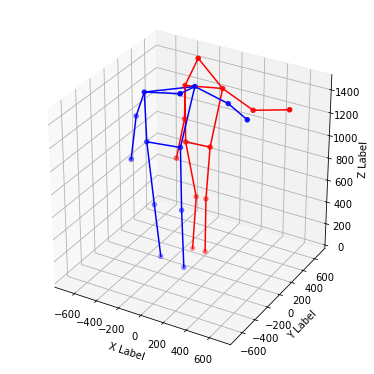

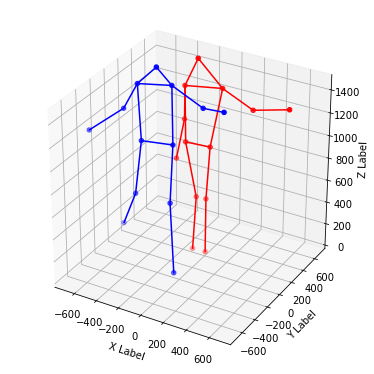

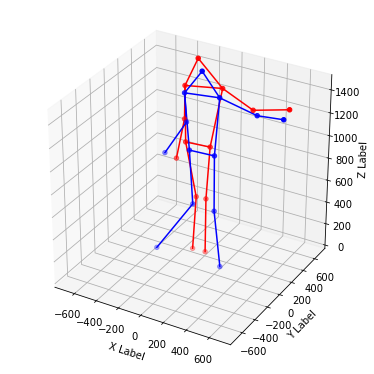

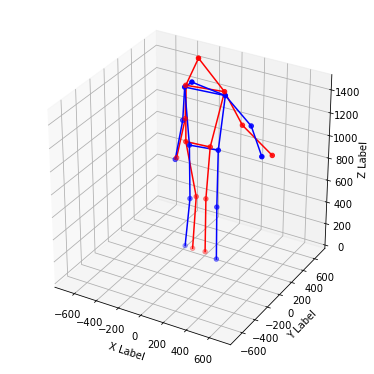

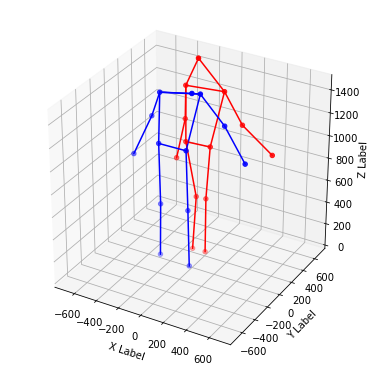

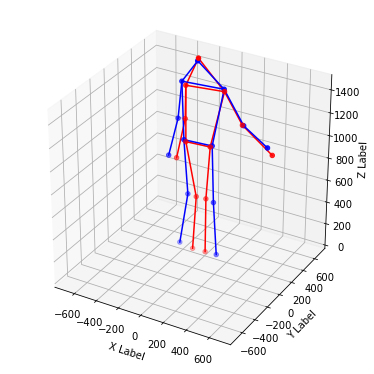

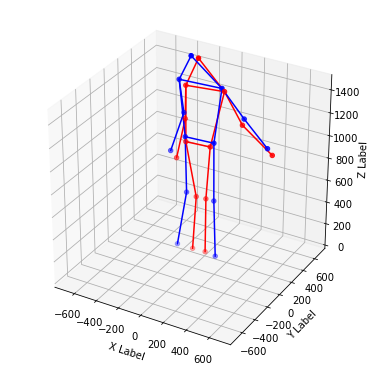

In [359]:
mp = metrics.MPJPE(reduction=average_loss)
with torch.no_grad():
    preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)


gts_xyz = y['xyz'][:16]
preds_xyz = []
for i in range(16):
    camera = y['camera'][i]
    M = y['M'][i]
    gt_skeleton = skeleton_helpers.Skeleton(y['skeleton'][i])
    
    pred_skeleton = skeleton_helpers.Skeleton(normalized_skeletons[i]).denormalize(width=346, height=260, torso_length=450, camera=camera)
    xyz_gt, xyz_pred = skeleton_helpers.plot_skeleton_3d(M, gt_skeleton, pred_skeleton)
    print(mp(xyz_gt._get_tensor(), xyz_pred._get_tensor()))
    preds_xyz.append(xyz_pred._get_tensor())
    
preds_xyz = torch.stack(preds_xyz)
print("MEAN:", mp(gts_xyz, preds_xyz))

tensor([75.7272], dtype=torch.float64)
tensor([86.0608], dtype=torch.float64)
tensor([87.9054], dtype=torch.float64)
tensor([78.5389], dtype=torch.float64)
tensor([104.9981], dtype=torch.float64)
tensor([129.4123], dtype=torch.float64)
tensor([72.9359], dtype=torch.float64)
tensor([60.7772], dtype=torch.float64)
tensor([113.0419], dtype=torch.float64)
tensor([126.0457], dtype=torch.float64)
tensor([169.7675], dtype=torch.float64)
tensor([110.8663], dtype=torch.float64)
tensor([81.7025], dtype=torch.float64)
tensor([94.5217], dtype=torch.float64)
tensor([63.8812], dtype=torch.float64)
tensor([56.0172], dtype=torch.float64)
tensor([88.7485], dtype=torch.float64)
tensor([90.6604], dtype=torch.float64)
tensor([63.3423], dtype=torch.float64)
tensor([86.9043], dtype=torch.float64)
tensor([109.1931], dtype=torch.float64)
tensor([115.4618], dtype=torch.float64)
tensor([102.3612], dtype=torch.float64)
tensor([65.4980], dtype=torch.float64)
tensor([109.4521], dtype=torch.float64)
tensor([639.237

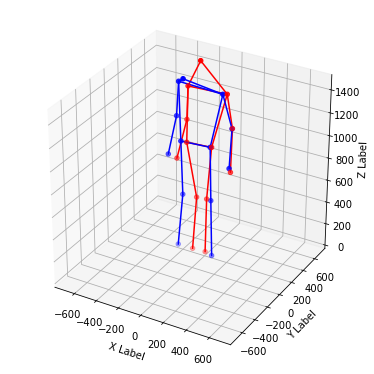

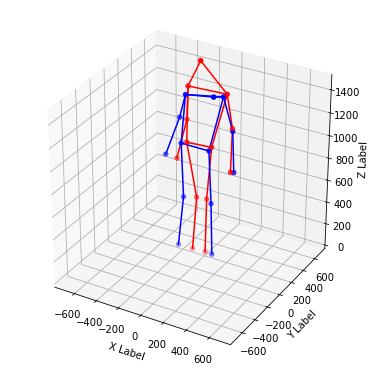

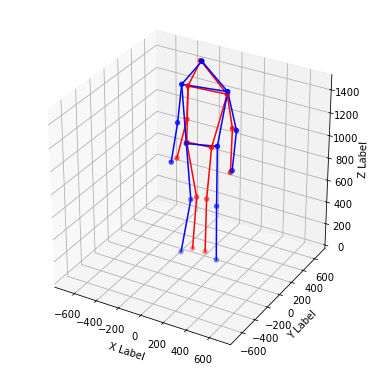

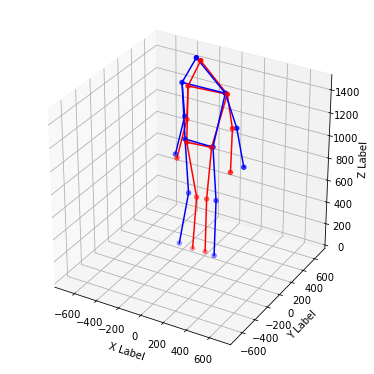

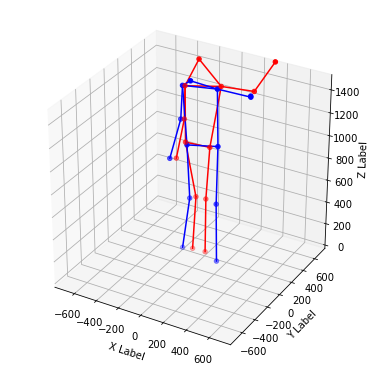

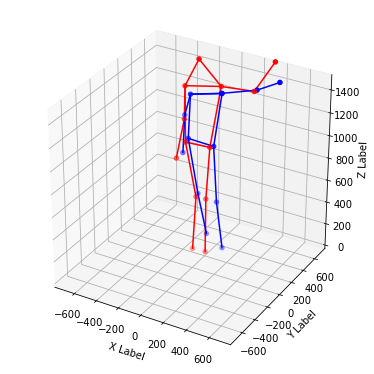

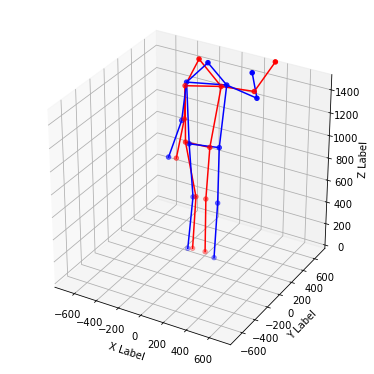

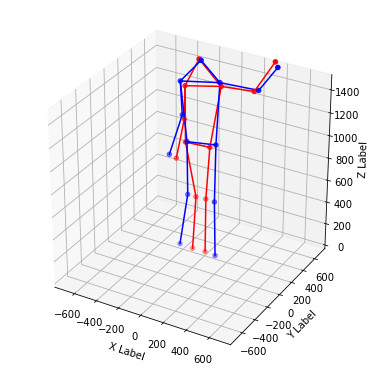

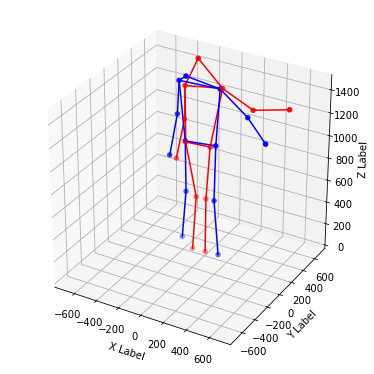

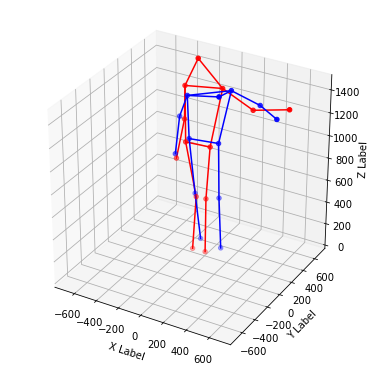

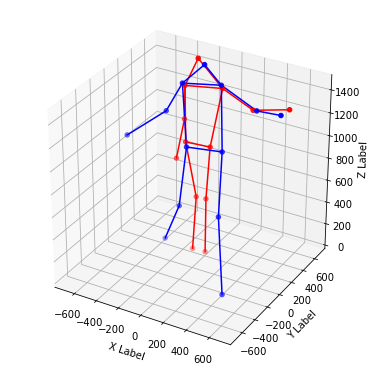

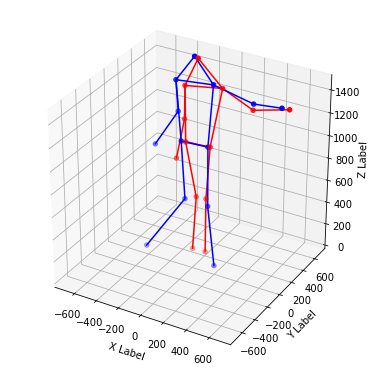

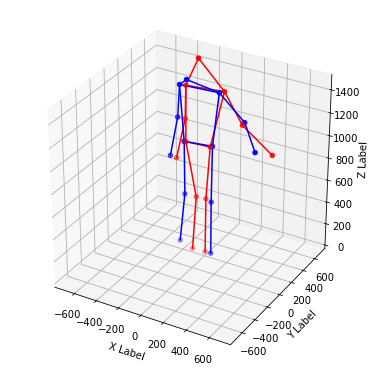

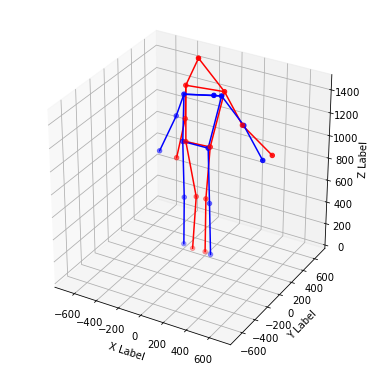

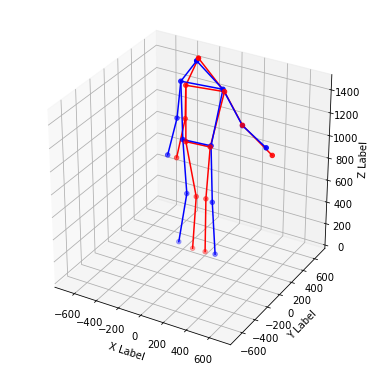

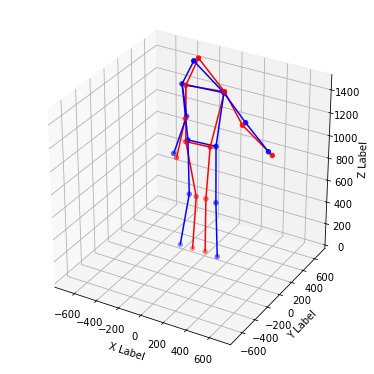

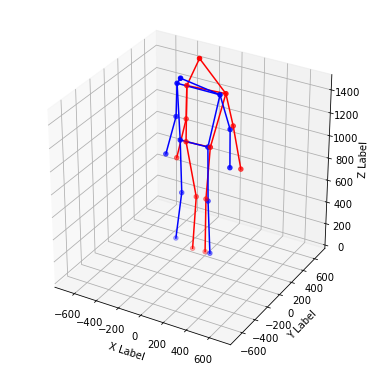

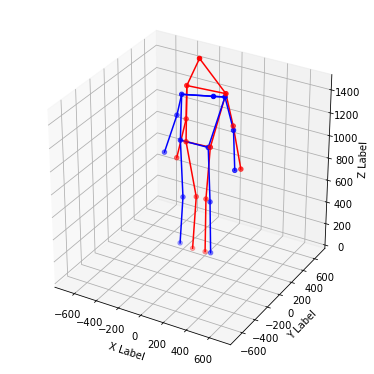

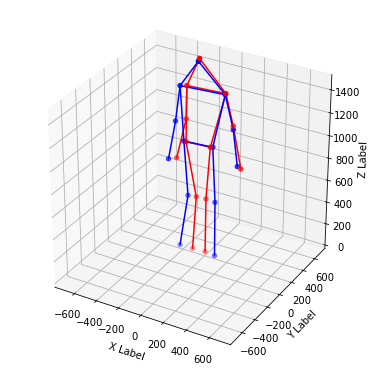

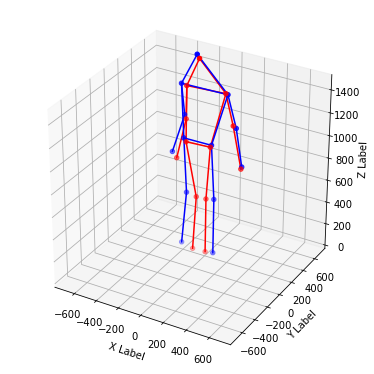

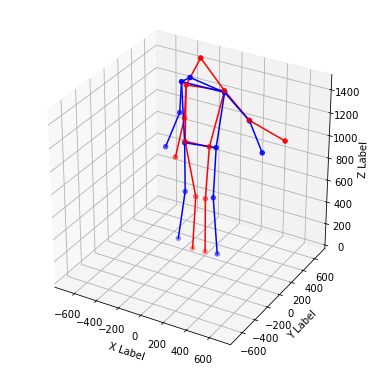

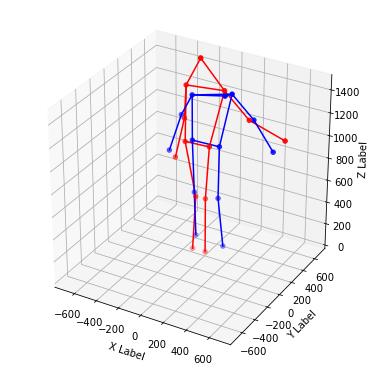

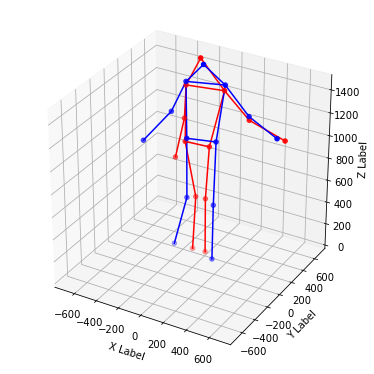

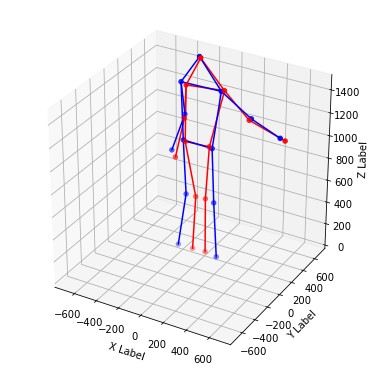

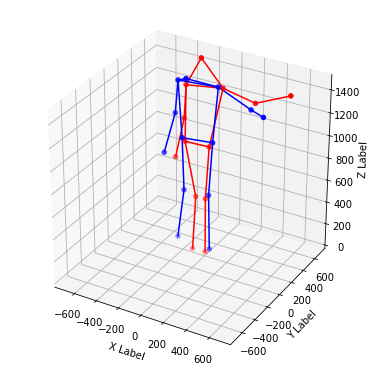

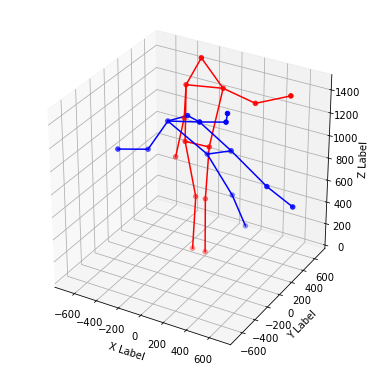

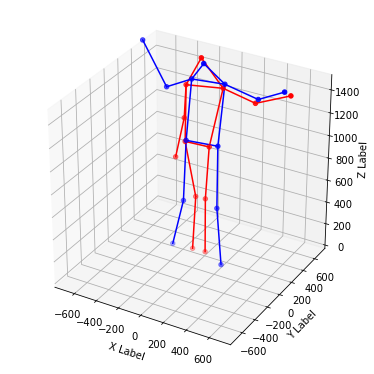

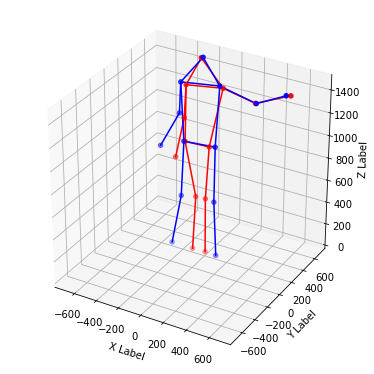

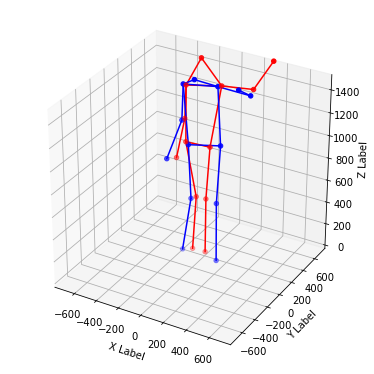

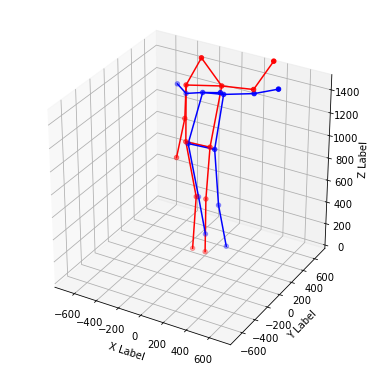

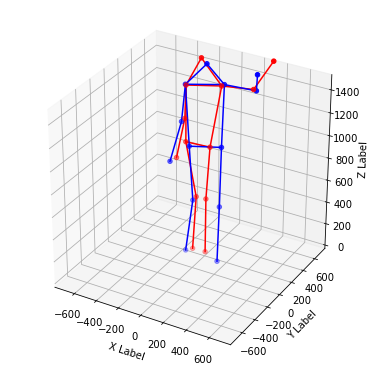

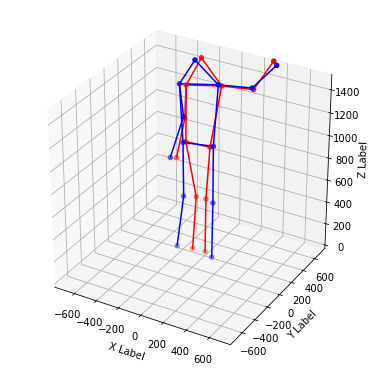

In [363]:
mp = metrics.MPJPE(reduction=average_loss)
with torch.no_grad():
    preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)
    
gts_xyz = y['xyz']
preds_xyz = []
for i in range(32):
    camera = y['camera'][i]
    M = y['M'][i]
    gt_skeleton = skeleton_helpers.Skeleton(y['skeleton'][i])
    pred_skeleton = skeleton_helpers.Skeleton(normalized_skeletons[i]).denormalize(width=346, height=260, z_ref=y['z_ref'][i], camera=camera)
    xyz_gt, xyz_pred = skeleton_helpers.plot_skeleton_3d(M, gt_skeleton, pred_skeleton)
    print(mp(xyz_gt._get_tensor(), xyz_pred._get_tensor()))
    preds_xyz.append(xyz_pred._get_tensor())
    
preds_xyz = torch.stack(preds_xyz)
print("MEAN:", mp(gts_xyz, preds_xyz))

# Test video 

In [214]:
import glob
import numpy as np
import h5py
import cv2

In [362]:
root_dir = os.path.join(homedir, dataset, "346x260/")

x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_*events.*")))

In [360]:
# Load matrix

P_mat_dir = os.path.join(homedir, 'P_matrices/')
P_mat_cam3 = np.load(os.path.join(P_mat_dir,'P2.npy'))
M,_ = decompose_projection_matrix(P_mat_cam3)


In [ ]:
x_h5 = h5py.File(x_paths[0], 'r')

In [ ]:
frames = x_h5['DVS'][..., 2]

In [364]:
os.listdir(root_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/data/gscarpellini/dhp19/voxel_grid_dataset/346x260/'

In [308]:
M, K = decompose_projection_matrix(P_mat_cam3)
K = torch.tensor(K)

In [310]:
K

tensor([[358.5965,   6.4216, 168.3375,   0.0000],
        [  0.0000, 359.4310, 126.4609,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000]], dtype=torch.float64)

In [244]:
aug = Compose([ToTensor()])
x

In [353]:
frames, y = next(iter(loader))
flat = frames.view(16 * 4, 260, 346)
camera = y['camera'][0]
M = y['M'][0]

In [366]:
# test video voxelgrid
root_dir = os.path.join(homedir, "voxel_grid_dataset", "movements_per_frame")

In [367]:
x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_.*")))

KeyboardInterrupt: 

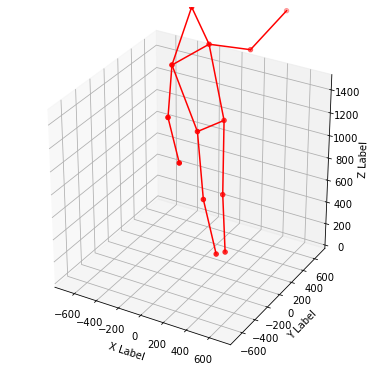

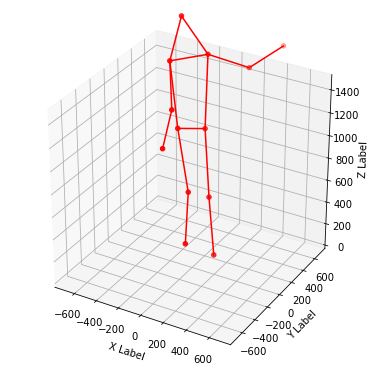

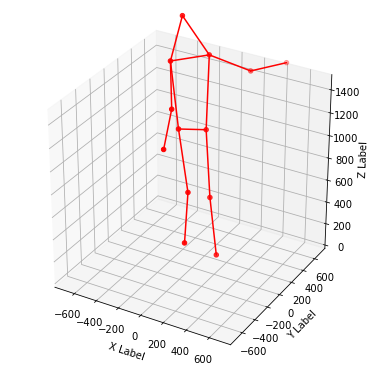

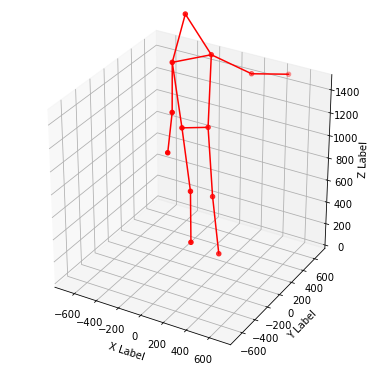

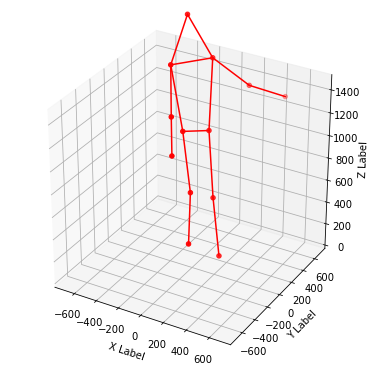

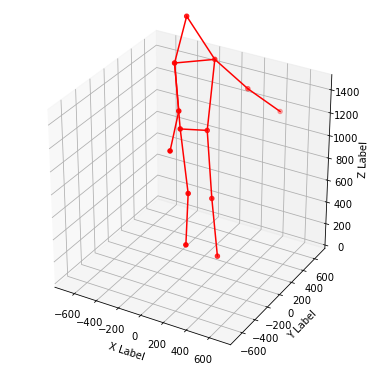

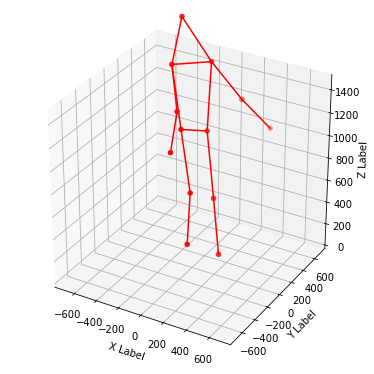

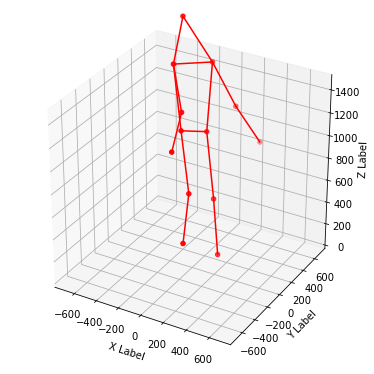

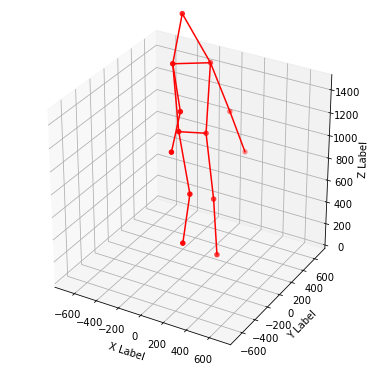

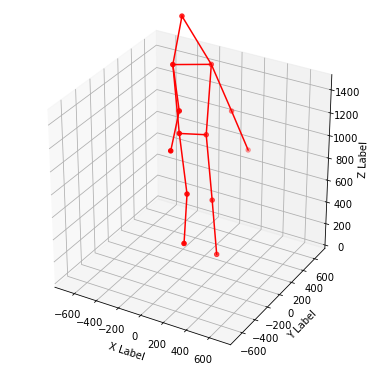

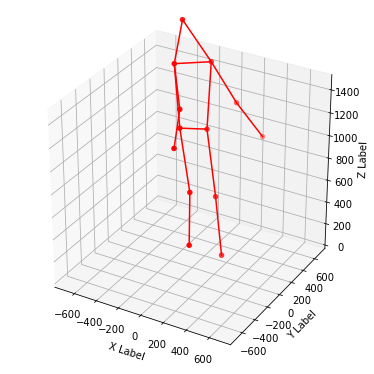

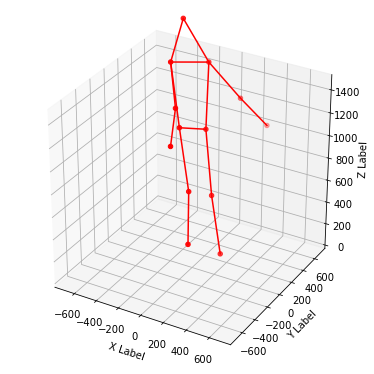

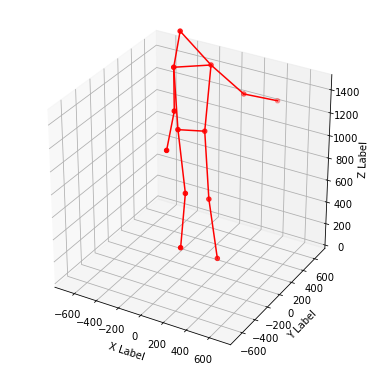

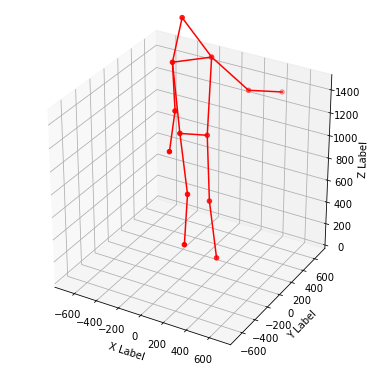

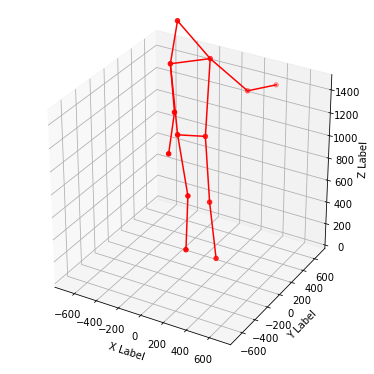

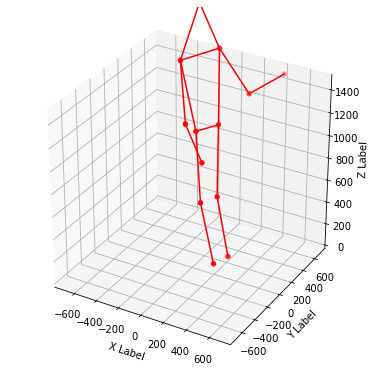

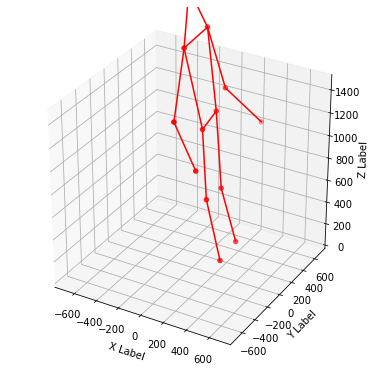

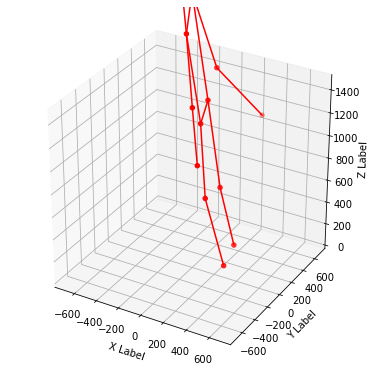

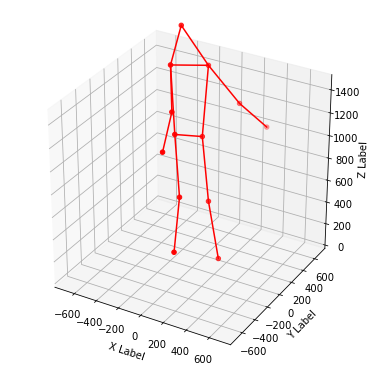

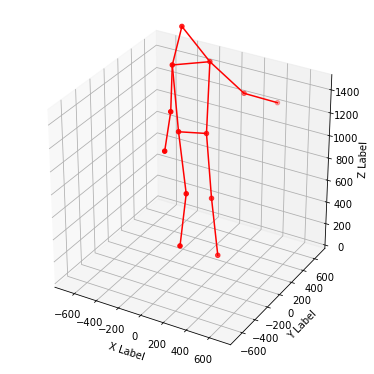

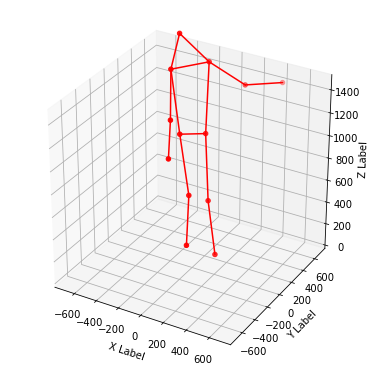

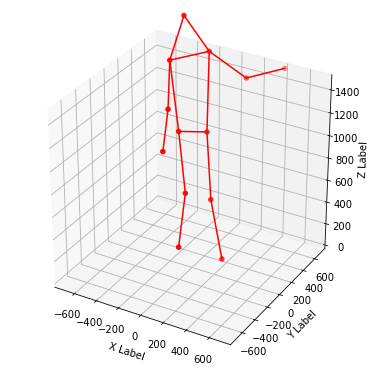

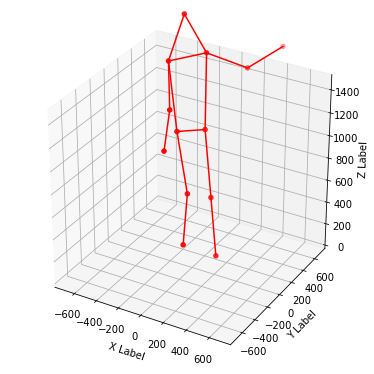

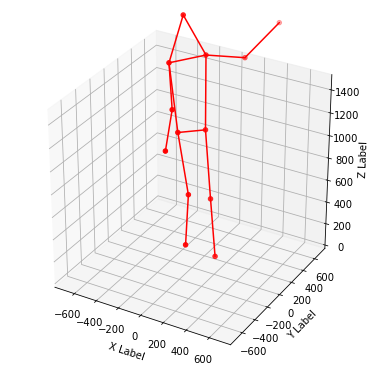

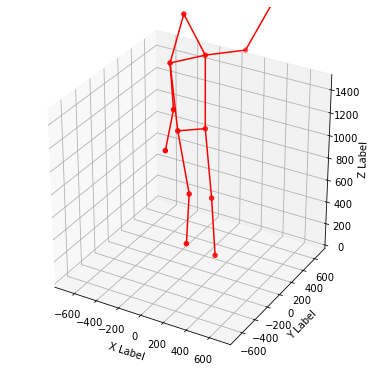

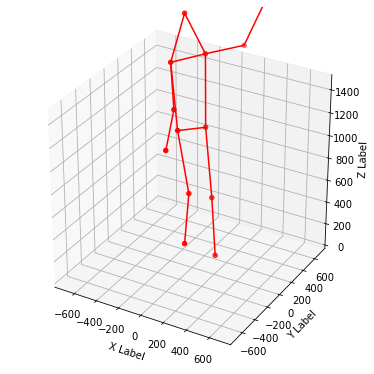

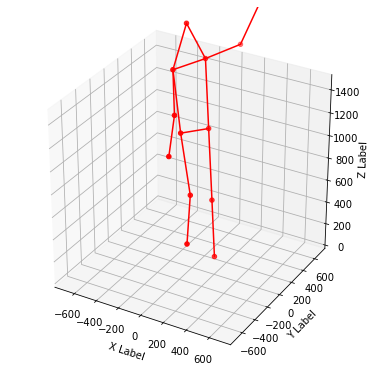

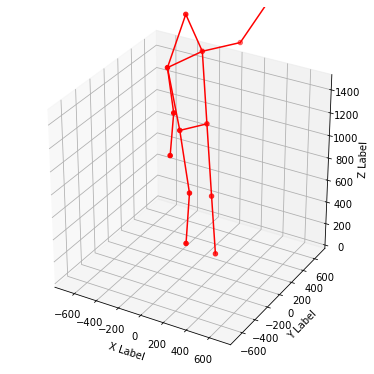

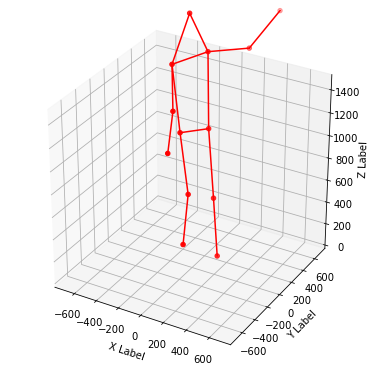

RuntimeError: Given groups=1, weight of size [64, 4, 7, 7], expected input[1, 3, 260, 346] to have 4 channels, but got 3 channels instead

In [356]:


for i in range(32, 64):
    x = torch.unsqueeze(flat[i:i+4, :, :], 0)
    with torch.no_grad():
        preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)
    normalized_skeletons
    
    pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
    pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  260, 346, camera).numpy().swapaxes(1, 0)

    utils.plot_skeleton_3d(M, pred_skeleton)
    plt.savefig(f'test{i}.png')
    plt.show()
    plt.close()

In [347]:
with torch.no_grad():
    for i in range(len(frames)):
        f = frames[i] / 255.
        f = f.swapaxes(0, 1)
        augmented = aug(image=f)
        x = augmented['image'].unsqueeze(0).unsqueeze(0)

        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)

        pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
        pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  260, 346, K).numpy().swapaxes(1, 0)

        utils.plot_skeleton_3d(M, pred_skeleton)
        plt.show()
        plt.savefig(f'test{i}.png')
        plt.close()


RuntimeError: Given groups=1, weight of size [64, 4, 7, 7], expected input[1, 1, 260, 346] to have 4 channels, but got 1 channels instead

In [277]:
writer = cv2.VideoWriter("input.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                      (346, 260))
for im in frames:
        f = im.swapaxes(0, 1)
        f = np.expand_dims(f, -1)
        f = np.concatenate([f, f, f], axis=-1)
        writer.write(f.astype('uint8'))
writer.release()



In [10]:
writer = cv2.VideoWriter("pred.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                         (360, 360))
images = sorted(glob.glob("*.png"))
for frame in images:
    im = cv2.imread(frame)
    writer.write(im.astype('uint8'))
writer.release()



NameError: name 'cv2' is not defined

In [9]:
frame.shape

NameError: name 'frame' is not defined